<a href="https://colab.research.google.com/github/Adithyanjohnson/vehicle-damage-detection-model-maskrccn/blob/main/surefeb24conformmobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import shutil

# Updated dataset paths
dataset_root = "/content/drive/MyDrive/dataset/CarDD_release"
dataset_path = os.path.join(dataset_root, "CarDD_release/CarDD_COCO")

train_annotations_path = os.path.join(dataset_path, "annotations/instances_train2017.json")
val_annotations_path = os.path.join(dataset_path, "annotations/instances_val2017.json")

train_images_path = os.path.join(dataset_path, "train2017")
val_images_path = os.path.join(dataset_path, "val2017")
test_images_path = os.path.join(dataset_path, "test2017")  # Test images path

# New directories for ImageDataGenerator
sorted_train_dir = os.path.join(dataset_root, "sorted_train")
sorted_val_dir = os.path.join(dataset_root, "sorted_val")
sorted_test_dir = os.path.join(dataset_root, "sorted_test")

# Function to create class-based directories
def create_class_dirs(output_dir, categories):
    for category in categories:
        os.makedirs(os.path.join(output_dir, category), exist_ok=True)

# Function to move images into class folders
def organize_images(json_path, images_path, output_dir):
    with open(json_path, "r") as f:
        coco_data = json.load(f)

    # Create category mapping
    category_map = {category["id"]: category["name"] for category in coco_data["categories"]}
    create_class_dirs(output_dir, category_map.values())

    # Move images into respective class folders
    for annotation in coco_data["annotations"]:
        image_id = annotation["image_id"]
        category_id = annotation["category_id"]
        image_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)

        if image_info:
            image_filename = image_info["file_name"]
            src_path = os.path.join(images_path, image_filename)
            dest_path = os.path.join(output_dir, category_map[category_id], image_filename)

            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)

# Organize train and validation datasets automatically
organize_images(train_annotations_path, train_images_path, sorted_train_dir)
organize_images(val_annotations_path, val_images_path, sorted_val_dir)

# If test2017 exists but has no annotations, just copy images into "unknown" class
if os.path.exists(test_images_path):
    os.makedirs(os.path.join(sorted_test_dir, "unknown"), exist_ok=True)
    for img_file in os.listdir(test_images_path):
        src_path = os.path.join(test_images_path, img_file)
        dest_path = os.path.join(sorted_test_dir, "unknown", img_file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dest_path)

print("✅ Dataset successfully structured for ImageDataGenerator!")


✅ Dataset successfully structured for ImageDataGenerator!


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Updated dataset path - Use dataset_root to maintain consistency
dataset_root = "/content/drive/MyDrive/dataset/CarDD_release" # Changed from dataset_path to dataset_root

# Define dataset directories
train_dir = os.path.join(dataset_root, "sorted_train")  # Now uses dataset_root
val_dir = os.path.join(dataset_root, "sorted_val")    # Now uses dataset_root
test_dir = val_dir  # Use validation set for testing if no separate test set exists

# ... (rest of the code remains the same) ...
# Data Augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2,
                                   horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)

# Only rescale for validation and testing
val_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=IMAGE_SIZE,
                                                batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = val_datagen.flow_from_directory(test_dir, target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Get class labels
class_names = list(train_generator.class_indices.keys())
print("✅ Class Labels:", class_names)

# ✅ Model Architecture - Using MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
EPOCHS = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Save Model
model.save("/content/drive/MyDrive/damage_detection_model.h5")
print("✅ Model saved successfully!")


Found 4360 images belonging to 6 classes.
Found 1237 images belonging to 6 classes.
Found 1237 images belonging to 6 classes.
✅ Class Labels: ['crack', 'dent', 'glass shatter', 'lamp broken', 'scratch', 'tire flat']


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.3733 - loss: 1.6172 - val_accuracy: 0.5230 - val_loss: 1.1503
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.4720 - loss: 1.2207 - val_accuracy: 0.5303 - val_loss: 1.1060
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.5320 - loss: 1.1284 - val_accuracy: 0.5271 - val_loss: 1.0896
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.5204 - loss: 1.1066 - val_accuracy: 0.5384 - val_loss: 1.0860
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.5170 - loss: 1.0981 - val_accuracy: 0.5222 - val_loss: 1.1274
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.5346 - loss: 1.0759 - val_accuracy: 0.5497 - val_loss: 1.0596
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.5345 - loss: 1.0757 - val_accuracy: 0.5424 - val_loss: 1.0730
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 525s 4s/step - accuracy: 0.5250 - loss: 1.0674 - val_accu

✅ Model saved successfully!


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert softmax output to class index

# Print evaluation metrics
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("🔍 Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("📊 Confusion Matrix:\n", cm)


39/39 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step
🔍 Classification Report:
                precision    recall  f1-score   support

        crack       0.50      0.02      0.03       122
         dent       0.46      0.41      0.44       352
glass shatter       0.74      0.96      0.84       134
  lamp broken       0.36      0.51      0.42       139
      scratch       0.57      0.63      0.60       431
    tire flat       0.65      0.83      0.73        59

     accuracy                           0.54      1237
    macro avg       0.55      0.56      0.51      1237
 weighted avg       0.53      0.54      0.51      1237

📊 Confusion Matrix:
 [[  2  45   2  23  46   4]
 [  1 144  24  48 126   9]
 [  0   3 128   1   1   1]
 [  0  33   3  71  30   2]
 [  1  81  14  53 272  10]
 [  0   4   1   0   5  49]]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get true labels
y_true = test_generator.classes

# Get predictions
y_pred_probs = model.predict(test_generator)  # Probabilities from softmax
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class indices

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average="weighted")
recall = recall_score(y_true, y_pred_classes, average="weighted")
f1 = f1_score(y_true, y_pred_classes, average="weighted")

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("🔍 Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("📊 Confusion Matrix:\n", cm)


39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step
✅ Accuracy: 0.5384
✅ Precision: 0.5314
✅ Recall: 0.5384
✅ F1 Score: 0.5081
🔍 Classification Report:
                precision    recall  f1-score   support

        crack       0.50      0.02      0.03       122
         dent       0.46      0.41      0.44       352
glass shatter       0.74      0.96      0.84       134
  lamp broken       0.36      0.51      0.42       139
      scratch       0.57      0.63      0.60       431
    tire flat       0.65      0.83      0.73        59

     accuracy                           0.54      1237
    macro avg       0.55      0.56      0.51      1237
 weighted avg       0.53      0.54      0.51      1237

📊 Confusion Matrix:
 [[  2  45   2  23  46   4]
 [  1 144  24  48 126   9]
 [  0   3 128   1   1   1]
 [  0  33   3  71  30   2]
 [  1  81  14  53 272  10]
 [  0   4   1   0   5  49]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


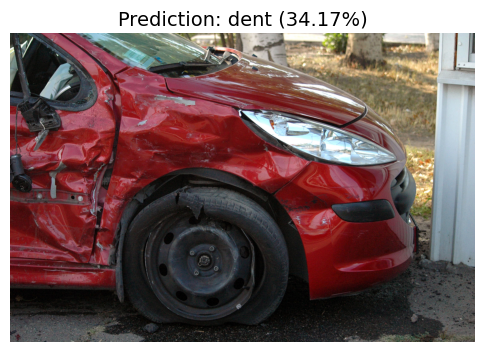

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("/content/drive/MyDrive/damage_detection_model.h5")

# Load and preprocess the image
image_path = "/content/drive/MyDrive/dataset/CarDD_release/CarDD_release/CarDD_COCO/test2017/000237.jpg"  # Change this to your test image

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from {image_path}. Check if the file is corrupted or if you have the correct permissions.")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, (224, 224))
        image_array = np.expand_dims(image_resized / 255.0, axis=0)  # Normalize and reshape

        # Predict class
        prediction = model.predict(image_array)
        predicted_class = np.argmax(prediction)
        predicted_label = class_names[predicted_class]
        confidence = prediction[0][predicted_class] * 100

        # Draw label on image
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=14)
        plt.axis("off")
        plt.show()

In [ ]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
